## Setup

In [12]:
from environment import CollisionChecker, construct_benchmark_environments
from planners.IPBasicPRM import BasicPRM
from optimize_path import OptimizeFlyby
import pprint
import networkx as nx
import numpy as np


## Load Environments

In [13]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [14]:
for name, item in env_dict.items():
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)
    # Inject Graph
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    planner.graph = G
    
    env_dict[name]["planner"] = planner



## Show the Environments

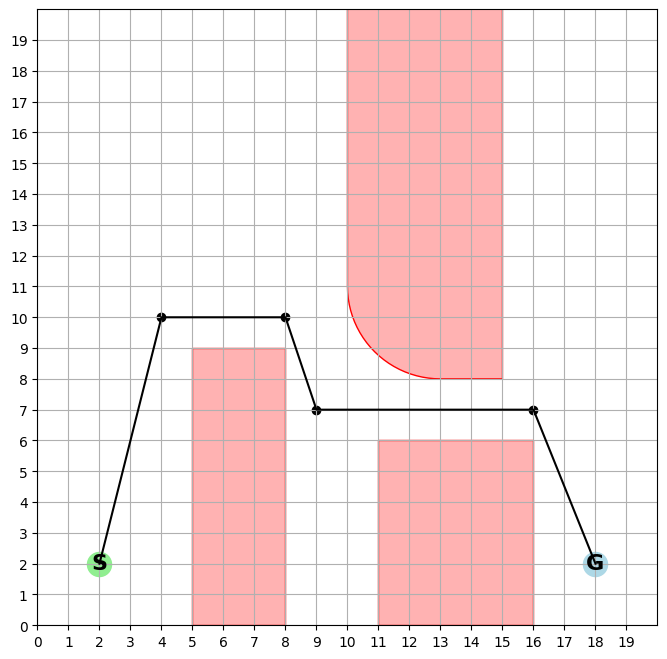

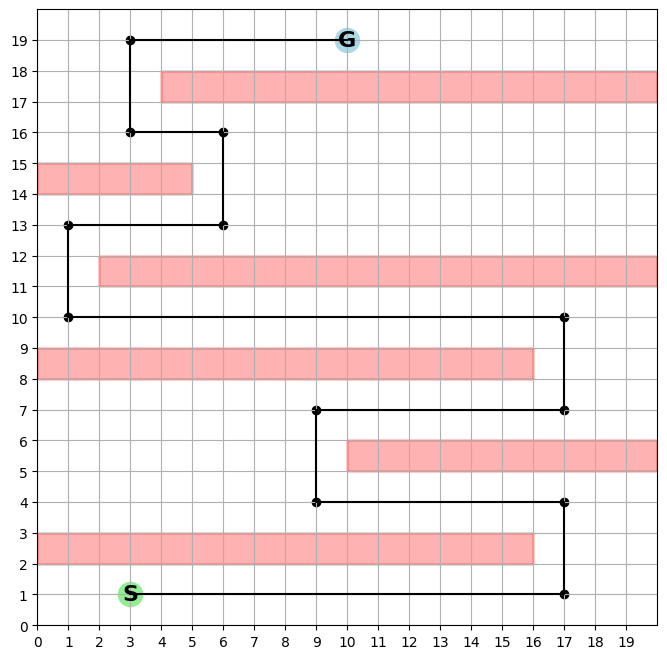

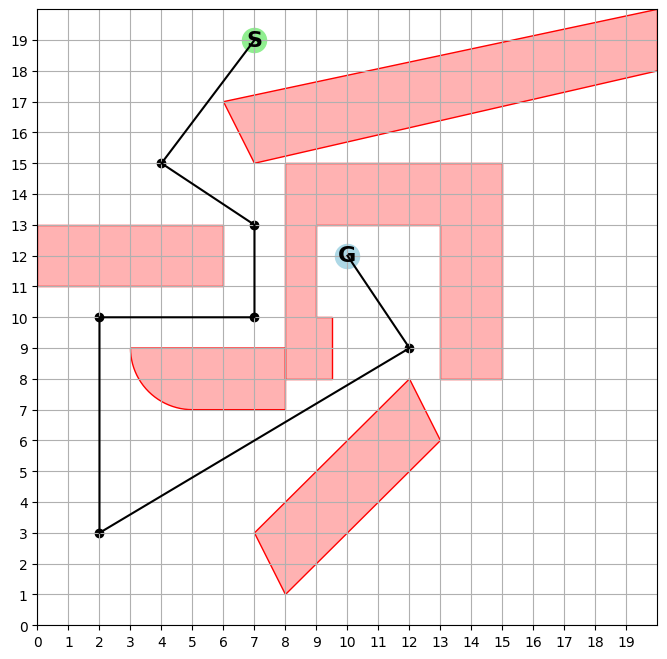

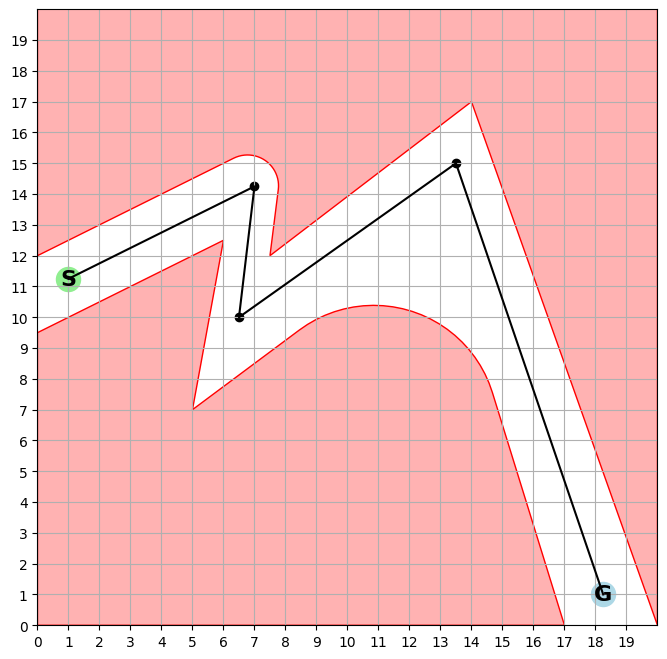

In [15]:
for name, item in env_dict.items():
    ax = item["planner"]._collisionChecker.draw_enviroments()
    item["planner"]._collisionChecker.draw_path(item["smooth_path"], ax=ax)


In [16]:
pprint.pprint(env_dict)

#print(env_dict.items)

{'1': {'env': {'obs_1': <POLYGON ((5 0, 8 0, 8 9, 5 9, 5 0))>,
               'obs_2': <POLYGON ((11 0, 16 0, 16 6, 11 6, 11 0))>,
               'obs_3': <POLYGON ((10 11, 10.006 10.804, 10.026 10.608, 10.058 10.415, 10.102 10.224...>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x744f53b63950>,
       'smooth_path': [(2.0, 2.0),
                       (4.0, 10.0),
                       (8.0, 10.0),
                       (9.0, 7.0),
                       (16.0, 7.0),
                       (18.0, 2.0)]},
 '2': {'env': {'obs_1': <POLYGON ((0 2, 16 2, 16 3, 0 3, 0 2))>,
               'obs_2': <POLYGON ((10 5, 20 5, 20 6, 10 6, 10 5))>,
               'obs_3': <POLYGON ((0 8, 16 8, 16 9, 0 9, 0 8))>,
               'obs_4': <POLYGON ((2 11, 20 11, 20 12, 2 12, 2 11))>,
               'obs_5': <POLYGON ((0 14, 5 14, 5 15, 0 15, 0 14))>,
               'obs_6': <POLYGON ((4 17, 20 17, 20 18, 4 18, 4 17))>},
       'planner': <planners.IPBasicPRM.BasicPRM object at 0x744f

# 2. Aufgabe

### Aufgabe 2a: Algorithmus & Kollisionsüberprüfung

In [17]:
enviroments = ['1','2','3','4']
all_results = {}
optimizer = OptimizeFlyby()
my_config = {'r_init': 0.49, 'r_min': 0.02, 'r_step': 0.01}

for j in enviroments:
    print(f"Berechne Environment {j}...")
    data = env_dict[j]
    planner = data["planner"]
    coords_path = data["smooth_path"]
    node_names_path = []

    for i, pos in enumerate(coords_path):
        node_name = f"P1_{i}"
        planner.graph.add_node(node_name, pos=pos)
        node_names_path.append(node_name)

    # Berechnung der r-Werte mit Kollisionsstrategie
    res = optimizer.optimizePath_combinedmodel(node_names_path, planner, my_config)
    all_results[j] = res
    
    print(f"Ergebnis Env {j}:")
    for entry in res:
        print(f"  {entry}")
    print("-" * 20)
    

Berechne Environment 1...
Ergebnis Env 1:
  ('P1_0', 0.0, 'none')
  ('P1_1', 0.23999999999999977, 'flyby')
  ('P1_2', 0.3899999999999999, 'flyby')
  ('P1_3', 0.49, 'flyby')
  ('P1_4', 0.3799999999999999, 'flyby')
  ('P1_5', 0.0, 'none')
--------------------
Berechne Environment 2...
Ergebnis Env 2:
  ('P1_0', 0.0, 'none')
  ('P1_1', 0.09999999999999969, 'flyby')
  ('P1_2', 0.49, 'flyby')
  ('P1_3', 0.17999999999999972, 'flyby')
  ('P1_4', 0.49, 'flyby')
  ('P1_5', 0.17999999999999972, 'flyby')
  ('P1_6', 0.49, 'flyby')
  ('P1_7', 0.08999999999999969, 'flyby')
  ('P1_8', 0.49, 'flyby')
  ('P1_9', 0.2999999999999998, 'flyby')
  ('P1_10', 0.49, 'flyby')
  ('P1_11', 0.49, 'flyby')
  ('P1_12', 0.49, 'flyby')
  ('P1_13', 0.0, 'none')
--------------------
Berechne Environment 3...
Ergebnis Env 3:
  ('P1_0', 0.0, 'none')
  ('P1_1', 0.3599999999999999, 'flyby')
  ('P1_2', 0.4099999999999999, 'flyby')
  ('P1_3', 0.49, 'flyby')
  ('P1_4', 0.49, 'cutting')
  ('P1_5', 0.49, 'flyby')
  ('P1_6', 0.14

### Aufgabe 2b: Visualisierung

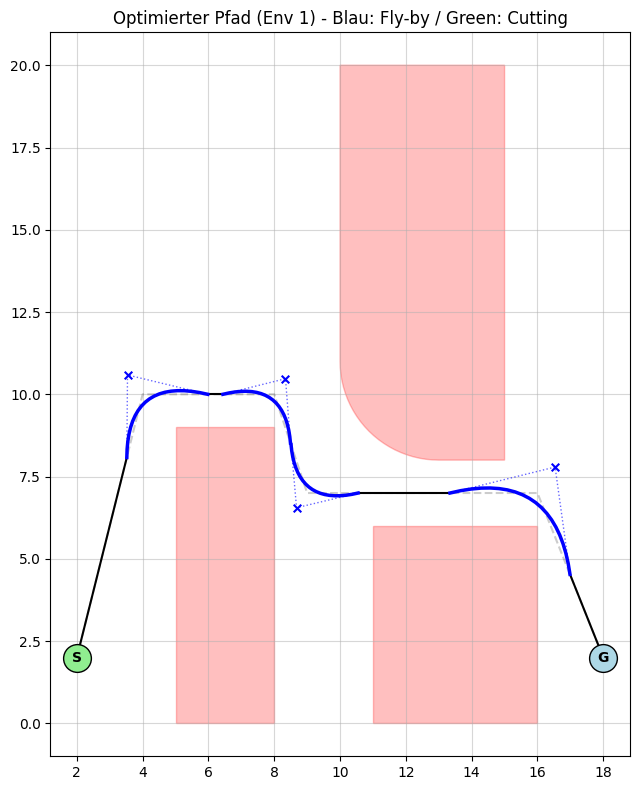

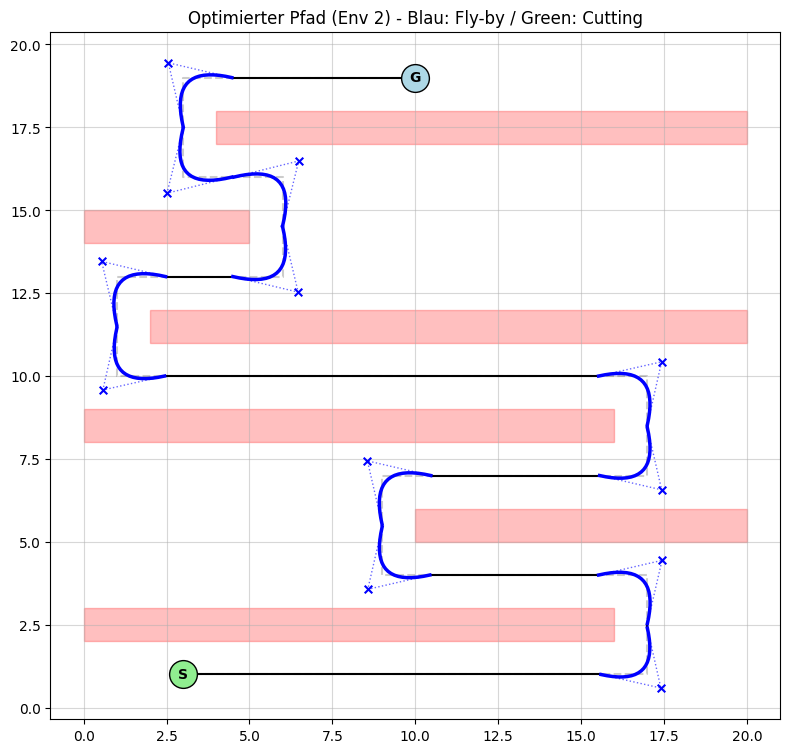

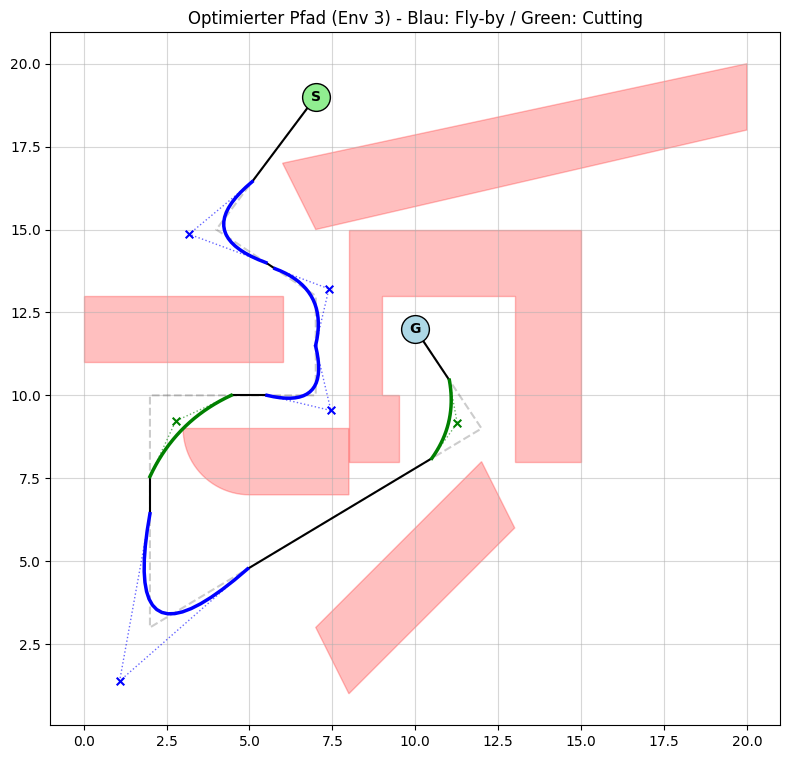

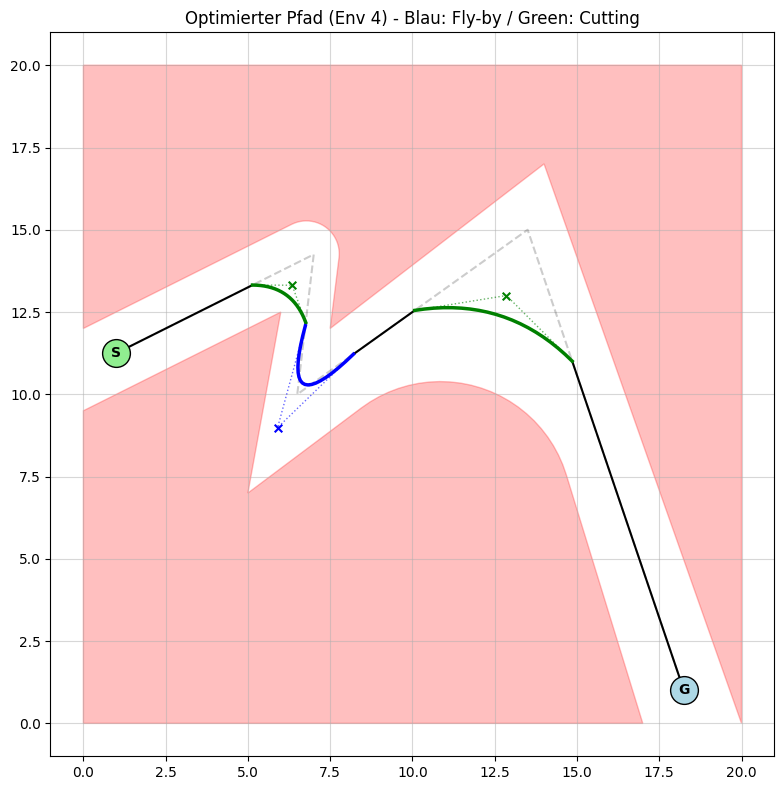

In [18]:
for j in enviroments:
    if j in all_results:
        optimizer.visualize_results(j, all_results[j], env_dict)